# TIME SERIES - PORT CITY SIMULATION DATA (CNR)

## Introduction


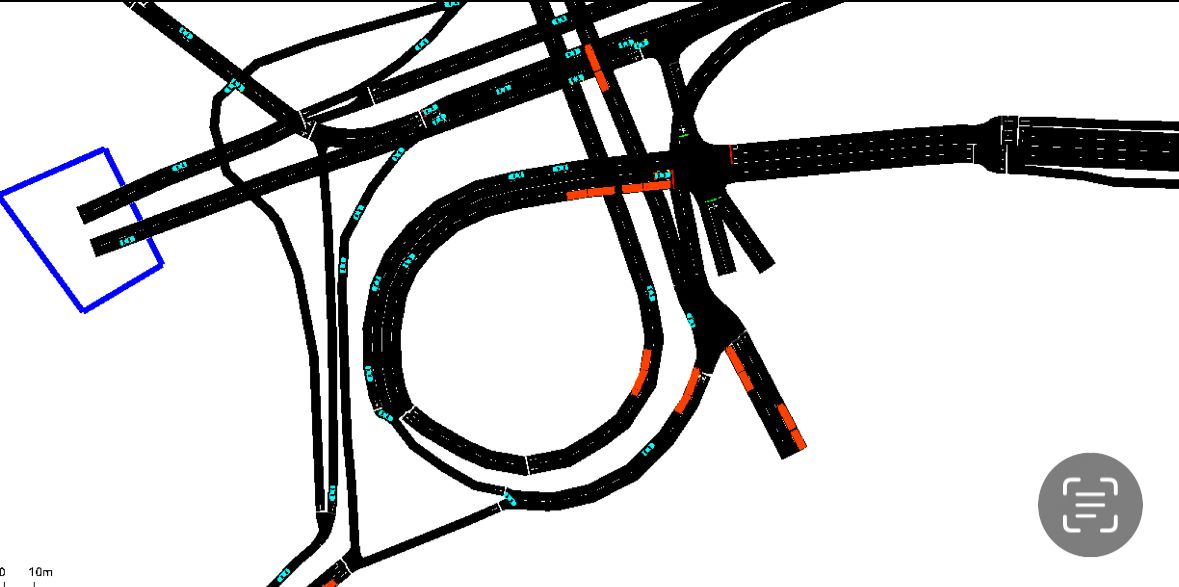


### **Purpose:**
Two pickle files contain data from simulations modeling traffic under two scenarios:
- **Scenario 0:** Standard traffic conditions.
- **Scenario 1:** One port gate is closed, forcing trucks to reroute.

### **Simulation Details:**
- **Runs:** 200 simulations, each lasting 1 hour.
- **Time Frames:** Data is aggregated into 12 time blocks (5 minutes each).
- **Network:** Includes 85 segments (edges).
- **Traffic:** Origin/destination flows of 25 sources (cars and trucks) are drawn from Gaussian distributions.

### **Variables in the Data:**
- **speed_all, speed_cars, speed_trucks:** Average speed on all edges for all vehicles, cars, and trucks respectively.
- **num_cars, num_trucks:** Average number of cars and trucks on all edges.
- **flow_cars, flow_trucks:** Average flow (vehicles reaching the end of edges) for cars and trucks.
- **inflows:** Input origin/destination traffic, reflecting policy changes.

## Import Dependencies & Pickle Files





In [ ]:
import pickle
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# path_scenario_0 = 'data_scenario0.pkl'
# path_scenario_1 = 'data_scenario1.pkl'
path_scenario_0 = '/content/drive/MyDrive/TESE/data/data_scenario0.pkl'
path_scenario_1 = '/content/drive/MyDrive/TESE/data/data_scenario1.pkl'
path_scenario_0_new = '/content/drive/MyDrive/TESE/data/data_scenario0_new.pkl'
path_scenario_1_new = '/content/drive/MyDrive/TESE/data/data_scenario1_new.pkl'


def import_pickle(path):
  if os.path.exists(path):
    with open(path, 'rb') as f:
      print("Pickle file imported from: ", path)
      return pickle.load(f)
  else:
    print("File not found.")

data_scenario_0 = import_pickle(path_scenario_0_new)
data_scenario_1 = import_pickle(path_scenario_1_new)

Pickle file imported from:  /content/drive/MyDrive/TESE/data_scenario0_new.pkl
Pickle file imported from:  /content/drive/MyDrive/TESE/data_scenario1_new.pkl


## Explore data variable shapes

In [ ]:
def show_shapes(data):
  for key, value in data.items():
    print(f"Variable: {key}")
    print(data[f'{key}'].shape)
    print(type(data[f'{key}']))
    print("-" * 20)

print("SCENARIO 0 \n")
show_shapes(data_scenario_0)
print("\n\n")
print("SCENARIO 1 \n")
show_shapes(data_scenario_1)

SCENARIO 0 

Variable: speed_all
(1000, 85, 12)
<class 'numpy.ndarray'>
--------------------
Variable: speed_cars
(1000, 85, 12)
<class 'numpy.ndarray'>
--------------------
Variable: speed_trucks
(1000, 85, 12)
<class 'numpy.ndarray'>
--------------------
Variable: num_cars
(1000, 85, 12)
<class 'numpy.ndarray'>
--------------------
Variable: num_trucks
(1000, 85, 12)
<class 'numpy.ndarray'>
--------------------
Variable: flow_cars
(1000, 85, 12)
<class 'numpy.ndarray'>
--------------------
Variable: flow_trucks
(1000, 85, 12)
<class 'numpy.ndarray'>
--------------------
Variable: inflows
(1000, 25)
<class 'numpy.ndarray'>
--------------------



SCENARIO 1 

Variable: speed_all
(1000, 85, 12)
<class 'numpy.ndarray'>
--------------------
Variable: speed_cars
(1000, 85, 12)
<class 'numpy.ndarray'>
--------------------
Variable: speed_trucks
(1000, 85, 12)
<class 'numpy.ndarray'>
--------------------
Variable: num_cars
(1000, 85, 12)
<class 'numpy.ndarray'>
--------------------
Variable

## Define variables

### Key Points for Analysis

The points identified are locations with the **highest interactions of car and truck flows**. These are expected to be most impacted by policy changes. The points are as follows:

#### 1. Lungomare Canepa (Eastbound)
- **Description**: Gathers traffic from trucks and cars moving west towards the Genova Ovest highway booth, and the east part of the city.  
- **Additional Traffic**: Includes trucks coming from the Etiopia Gate.

#### 2. Via di Francia (Eastbound)
- **Description**: Often congested, especially during heavy ferry traffic.

#### 3. Elicoidale "Downstream"
- **Location**: Part of the Elicoidale roundabout near the Genova Ovest highway booth.  
- **Description**: Collects trucks from the highway and mobility traffic.

#### 4. Elicoidale "Upstream"
- **Location**: Another portion of the Elicoidale roundabout, handling trucks coming from the San Benigno Gate.  
- **Description**: Routes traffic towards the Genova Ovest highway booth and mobility traffic.

---

### Corresponding Data Indices

In the data provided, these points correspond to the following indices in the matrices (range: 0–84 in Python style):

| **Point**            | **Index** |
|-----------------------|-----------|
| Lungomare Canepa     | 43        |
| Via di Francia        | 70        |
| Elicoidale "Downstream" | 6       |
| Elicoidale "Upstream" | 62        |

---

### Additional Notes

- **Initial Selection**: These points were chosen **a priori**, based on expected behavior.  
- **Further Adjustments**: Modifications might be needed as insights are derived from the analysis.  
- **Starting Point**: These locations provide a solid foundation for the analysis.

In [ ]:
# Define the road segment k
interesting_k=[6, 43, 62, 70]

segments_k = {
    "Lungomare Canepa": 43,
    "Via di Francia": 70,
    "Elicoidale Downstream": 6,
    "Elicoidale Upstream": 62
}

def get_key_by_value(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key
    return None


# Number of time chunks
num_time_chunks = 12

# Define the list of variables and their names
variables_s0 = [data_scenario_0['speed_cars'],data_scenario_0['speed_trucks'],
                data_scenario_0['num_cars'], data_scenario_0['num_trucks'],
                data_scenario_0['flow_cars'], data_scenario_0['flow_trucks']]

variables_s1 = [data_scenario_1['speed_cars'],data_scenario_1['speed_trucks'],
                data_scenario_1['num_cars'], data_scenario_1['num_trucks'],
                data_scenario_1['flow_cars'], data_scenario_1['flow_trucks']]

variable_names = ["Speed Cars", "Speed Trucks", "Number of Cars", "Number of Trucks", "Flow Cars", "Flow Trucks"]

aggregation_types = {
    "Speed Cars": "mean",
    "Speed Trucks": "mean",
    "Number of Cars": "mean",
    "Number of Trucks": "mean",
    "Flow Cars": "sum",
    "Flow Trucks": "sum"
}

timechunk_step = 1

index_segments_k = {
    "Lungomare Canepa": 1,
    "Via di Francia": 3,
    "Elicoidale Downstream": 0,
    "Elicoidale Upstream": 2
}

batch_sizes = [8, 16, 32, 64, 100]

# Number of variables
num_variables = len(variable_names)

## Reaggregate Variables in Multivariate Time Series format

The idea here is to have the TS data as a np.ndarray with shape (number_of_interesting_k * num_variables, n, t), where n is the amount of simulation runs and t is the amount of timechunks

In [ ]:
def reaggregate_variables(data, interesting_k, variable_list):
    num_runs, num_segments, num_time_chunks = variable_list[0].shape  # Assumes all variable shapes are equal
    num_interesting_k = len(interesting_k)
    num_variables = len(variable_list)

    # Changed the shape of reaggregated_data to (number_of_interesting_k * num_variables, n, t)
    reaggregated_data = np.zeros((num_interesting_k * num_variables, num_runs, num_time_chunks))

    for i, k in enumerate(interesting_k):
        for j, variable in enumerate(variable_list):
            # Now assigning data for each segment k across all simulation runs and time chunks
            reaggregated_data[i * num_variables + j, :, :] = variable[:, k, :]
    return reaggregated_data


In [ ]:
# Scenario 0:
reaggregated_s0 = reaggregate_variables(data_scenario_0, interesting_k, variables_s0)
print(reaggregated_s0.shape)

# Scenario 1:
reaggregated_s1 = reaggregate_variables(data_scenario_1, interesting_k, variables_s1)
reaggregated_s1.shape

(24, 1000, 12)


(24, 1000, 12)

In [ ]:
def aggregate_timechunks(data, timechunk_step, aggregation_types):
    """
    Aggregates time chunks in a NumPy array based on specified steps and aggregation types.

    Args:
        data (np.ndarray): The input data with shape (num_variables, num_runs, num_time_chunks).
        timechunk_step (int): The number of time chunks to aggregate into one.
        aggregation_types (dict): A dictionary where keys are variable names and values are aggregation types ('mean' or 'sum').

    Returns:
        np.ndarray: The aggregated data.
    """

    num_variables, num_runs, num_time_chunks = data.shape
    new_num_time_chunks = num_time_chunks // timechunk_step

    aggregated_data = np.zeros((num_variables, num_runs, new_num_time_chunks))

    for var_idx in range(num_variables):
        # The modulo operator (%) ensures the index wraps around to stay within the range of variable_names
        var_name_idx = var_idx % len(variable_names) # This is the key change
        for run_idx in range(num_runs):
            for new_chunk_idx in range(new_num_time_chunks):
                start_idx = new_chunk_idx * timechunk_step
                end_idx = (new_chunk_idx + 1) * timechunk_step
                chunk = data[var_idx, run_idx, start_idx:end_idx]

                if aggregation_types[variable_names[var_name_idx]].lower() == 'mean': # Using var_name_idx here
                    aggregated_data[var_idx, run_idx, new_chunk_idx] = np.mean(chunk)
                elif aggregation_types[variable_names[var_name_idx]].lower() == 'sum': # Using var_name_idx here
                    aggregated_data[var_idx, run_idx, new_chunk_idx] = np.sum(chunk)
                else:
                    raise ValueError(f"Invalid aggregation type: {aggregation_types[variable_names[var_idx]]}")

    return aggregated_data


aggregated_s0 = aggregate_timechunks(reaggregated_s0, timechunk_step, aggregation_types)
print(aggregated_s0.shape)

aggregated_s1 = aggregate_timechunks(reaggregated_s1, timechunk_step, aggregation_types)
print(aggregated_s1.shape)

(24, 1000, 12)
(24, 1000, 12)


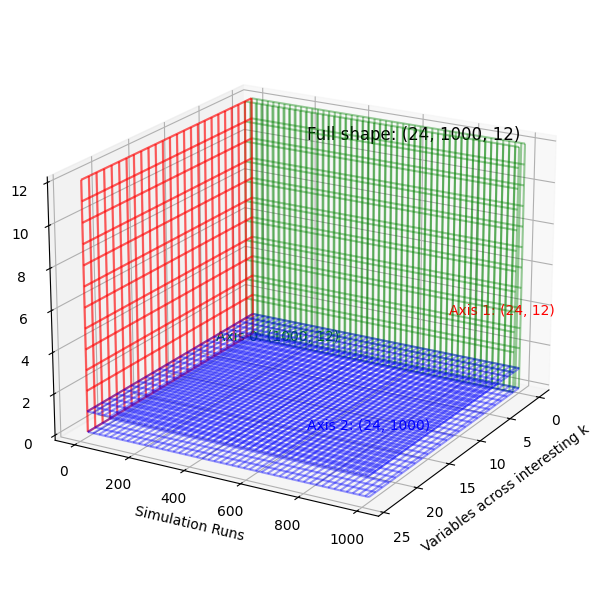

In [ ]:
def visualize_array_shape(shape):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Create a grid for visualizing the array
    x, y, z = np.meshgrid(
        np.arange(shape[0] + 1),
        np.arange(shape[1] + 1),
        np.arange(shape[2] + 1)
    )

    # Draw the outer box
    for i in range(2):
        ax.plot_wireframe(x[i, :, :], y[i, :, :], z[i, :, :], color="red", alpha=0.4)  # Sides along axis 0
        ax.plot_wireframe(x[:, i, :], y[:, i, :], z[:, i, :], color="green", alpha=0.4)  # Sides along axis 1
        ax.plot_wireframe(x[:, :, i], y[:, :, i], z[:, :, i], color="blue", alpha=0.4)  # Sides along axis 2

    # Annotations
    ax.text(shape[0] // 2, shape[1] // 2, shape[2] + 1, f"Full shape: {shape}", color="black", fontsize=12)
    ax.text(shape[0] + 1, shape[1] // 2, shape[2] // 2, f"Axis 0: ({shape[1]}, {shape[2]})", color="green", fontsize=10)
    ax.text(shape[0] // 2, shape[1] + 1, shape[2] // 2, f"Axis 1: ({shape[0]}, {shape[2]})", color="red", fontsize=10)
    ax.text(shape[0] // 2, shape[1] // 2, -1, f"Axis 2: ({shape[0]}, {shape[1]})", color="blue", fontsize=10)

    # Adjust view and plot
    ax.view_init(20, 30)
    ax.set_xlabel("Variables across interesting k")
    ax.set_ylabel("Simulation Runs")
    ax.set_zlabel("Timechunks")
    plt.tight_layout()
    plt.show()

visualize_array_shape(aggregated_s0.shape)

## Time Series Analysis

Here, we are monitoring day-wise time series. This means that we need to have times series at a fixed time (e.g. 9:05) for all the available days (simulation runs). In other words, the time variable of the TS is the simulation run n.

### Plot functions

In [ ]:
def plot_timechunks_side_by_side(k, aggregated_s0, aggregated_s1, variable_names):
    num_variables = len(variable_names)
    num_time_chunks = aggregated_s0.shape[2]

    fig, axes = plt.subplots(
        nrows=num_time_chunks,
        ncols=num_variables,
        figsize=(5 * num_variables, 4 * num_time_chunks),
        constrained_layout=True
    )

    for t in range(num_time_chunks):
        for i, name in enumerate(variable_names):
            # Calculate the index for the current variable and segment
            var_index = k * num_variables + i

            # Extract aggregated data for the current time chunk and variable
            data_s0 = aggregated_s0[var_index, :, t]
            data_s1 = aggregated_s1[var_index, :, t]

            ax = axes[t, i] if num_time_chunks > 1 else axes[i]
            ax.plot(data_s0, label=f"{name} - Scenario 0")
            ax.plot(data_s1, label=f"{name} - Scenario 1")
            ax.set_title(f"Aggregated Time Chunk {t + 1} - {name}")
            ax.set_xlabel("Runs")
            ax.set_ylabel("Aggregated Values")
            ax.legend()

    plt.show()


In [ ]:
def plot_timechunks_residuals(k, aggregated_s0, aggregated_s1, variable_names):
    num_variables = len(variable_names)
    num_time_chunks = aggregated_s0.shape[2]

    fig, axes = plt.subplots(
        nrows=num_time_chunks,
        ncols=num_variables,
        figsize=(5 * num_variables, 4 * num_time_chunks),
        constrained_layout=True
    )

    for t in range(num_time_chunks):
        for i, name in enumerate(variable_names):
            # Calculate the index for the current variable and segment
            var_index = k * num_variables + i

            # Extract aggregated data for the current time chunk and variable
            data_s0 = aggregated_s0[var_index, :, t]
            data_s1 = aggregated_s1[var_index, :, t]
            residuals = data_s0 - data_s1  # Calculate residuals

            ax = axes[t, i] if num_time_chunks > 1 else axes[i]
            ax.plot(residuals, label=f"{name} Residuals", color="red")
            ax.axhline(0, color="black", linestyle="--", linewidth=0.8)  # Reference line for zero residual
            ax.set_title(f"Aggregated Time Chunk {t + 1} - {name}")
            ax.set_xlabel("Runs")
            ax.set_ylabel("Residuals")
            ax.legend()

    plt.show()

### Two-Sample Hotelling's T^2 test

The null hypothesis is that the two groups have the same multivariate mean

In [ ]:
def hotelling_t2_test(group1, group2):
    """
    Perform the two-sample Hotelling's T² test.

    Parameters:
        group1 (ndarray): Data for group 1, shape (n1, p)
        group2 (ndarray): Data for group 2, shape (n2, p)

    Returns:
        dict: A dictionary containing T² statistic, F-statistic, degrees of freedom, and p-value.
    """
    # Sizes of the groups
    n1, p = group1.shape
    n2, _ = group2.shape

    # Means of each group
    mean1 = np.mean(group1, axis=0)
    mean2 = np.mean(group2, axis=0)

    # Covariance matrices for each group
    S1 = np.cov(group1, rowvar=False)
    S2 = np.cov(group2, rowvar=False)

    # Pooled covariance matrix
    Sp = ((n1 - 1) * S1 + (n2 - 1) * S2) / (n1 + n2 - 2)

    # Mean difference
    mean_diff = mean1 - mean2

    # Hotelling's T² statistic
    T2_stat = (n1 * n2) / (n1 + n2) * mean_diff @ np.linalg.inv(Sp) @ mean_diff.T

    # Convert T² statistic to an F-statistic
    F_stat = (T2_stat * (n1 + n2 - p - 1)) / (p * (n1 + n2 - 2))
    df1 = p  # Degrees of freedom 1
    df2 = n1 + n2 - p - 1  # Degrees of freedom 2

    # p-value
    p_value = 1 - f.cdf(F_stat, df1, df2)

    # Return results
    return {
        "T2_statistic": T2_stat,
        "F_statistic": F_stat,
        "df1": df1,
        "df2": df2,
        "p_value": p_value
    }

In [ ]:
def create_groups_for_hotelling(k, aggregated_s0, aggregated_s1, variable_names, time_chunk, batch_size):
    """
    Creates data groups for Hotelling's T^2 test for a given segment (k), time chunk, and batch size.

    Args:
        k (int): Index of the road segment.
        aggregated_s0 (np.ndarray): Aggregated data for scenario 0.
        aggregated_s1 (np.ndarray): Aggregated data for scenario 1.
        variable_names (list): List of variable names.
        time_chunk (int): Index of the time chunk to consider.
        batch_size (int): Number of simulation runs to include in each group.

    Returns:
        tuple: A tuple containing two NumPy arrays representing the data groups for scenario 0 and scenario 1,
               or None if invalid inputs are provided.
    """
    num_variables = len(variable_names)
    num_time_chunks = aggregated_s0.shape[2]
    num_runs = aggregated_s0.shape[1]

    if not (0 <= k < aggregated_s0.shape[0] // num_variables and 0 <= time_chunk < num_time_chunks and 0 < batch_size <= num_runs):
        print(f"Invalid input parameters. k: {k}, time_chunk: {time_chunk}, batch_size: {batch_size}")
        print(f"Valid range for k: [0, {aggregated_s0.shape[0] // num_variables - 1}], "
              f"time_chunk: [0, {num_time_chunks - 1}], "
              f"batch_size: (0, {num_runs}]")
        return None

    # Extract data for the specified segment 'k', all variables, the specified time chunk, and batch size
    group_s0 = aggregated_s0[k * num_variables:(k + 1) * num_variables, :batch_size, time_chunk]
    group_s1 = aggregated_s1[k * num_variables:(k + 1) * num_variables, :batch_size, time_chunk]

    return group_s0.T, group_s1.T

#### Testing Implementation

Testing the Code

To ensure correctness, you can test your function with 3 examples that involve:

    Small data matrices (easy to verify manually).
    Larger datasets to confirm computational stability.
    Edge cases (e.g., groups with identical means, extreme covariance values).

Test 1: Small, Simple Data

Manually compute expected results for two small groups.

Expected result: moderate T2 statistic and a small p-value, indicating significant differences between groups.

In [ ]:
group1 = np.array([[4.2, 2.5], [3.9, 2.7], [4.3, 2.8]])
group2 = np.array([[5.1, 3.3], [5.3, 3.1], [5.0, 3.5]])

result = hotelling_t2_test(group1, group2)
print("Test 1:", result)

Test 1: {'T2_statistic': 110.51177904142997, 'F_statistic': 41.44191714053624, 'df1': 2, 'df2': 3, 'p_value': 0.0065285200794436005}


Test 2: Larger Groups

Introduce larger groups and verify statistical results.

Expected result: a larger T2 statistic and a very small p-value (assuming noticeable group differences).

In [ ]:
np.random.seed(42)  # For reproducibility
group1 = np.random.multivariate_normal([5, 10, 15], np.eye(3), size=50)
group2 = np.random.multivariate_normal([6, 11, 16], np.eye(3), size=50)

result = hotelling_t2_test(group1, group2)
print("Test 2:", result)


Test 2: {'T2_statistic': 144.6490876285198, 'F_statistic': 47.23235514400646, 'df1': 3, 'df2': 96, 'p_value': 1.1102230246251565e-16}


Test 3: Identical Means

Use groups with pratically identical means; T2 and F-statistic should be 0, and p-value should be 1.0.

Expected result: small T2, near zero F, and p prox. to 1.0 (pratically no group difference).

In [ ]:
group1 = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
group2 = group1.copy() + np.random.rand(group1.shape[0], group1.shape[1]) * 1e-6  # Add a small random perturbation

result = hotelling_t2_test(group1, group2)
print("Test 3:", result)

Test 3: {'T2_statistic': 2.5858788662460155, 'F_statistic': 0.4309798110410026, 'df1': 3, 'df2': 2, 'p_value': 0.7539679657690026}


## False Positive Rate

In [ ]:
def calculate_false_positive_rate(aggregated_data, k, B, num_iterations, variable_names):
    """
    Calculates the false positive rate using Hotelling's T^2 test.

    Args:
        aggregated_data (np.ndarray): Aggregated data for a scenario.
        k (int): Index of the road segment.
        B (int): Batch size.
        num_iterations: Number of iterations to run

    Returns:
        float: The false positive rate.
    """

    num_runs = aggregated_data.shape[1]
    num_variables = len(variable_names)
    num_time_chunks = aggregated_data.shape[2]
    false_positives = 0

    for _ in range(num_iterations): # Iterate over a subset of timechunks
        for t in range(num_time_chunks):
          for i in range(0, num_runs - 2 * B +1, B):
              group1 = aggregated_data[k * num_variables:(k+1) * num_variables, i: i+B, t].T
              group2 = aggregated_data[k * num_variables:(k+1) * num_variables, i + B : i + 2*B, t].T

              # Perform Hotelling's T^2 test
              result = hotelling_t2_test(group1, group2)

              # Check if the null hypothesis is rejected (false positive)
              if result["p_value"] < 0.05:
                  false_positives += 1
    return false_positives / (num_iterations * num_time_chunks * (num_runs // B)) # Normalize by the number of tests

In [ ]:
def fpr_analysis(aggregated_data, k, variable_names):
  num_runs = aggregated_data.shape[1]
  for B in batch_sizes:
    num_iterations = math.floor(num_runs / B)
    fpr = calculate_false_positive_rate(aggregated_s0, k, B, num_iterations, variable_names)
    print(f"False Positive Rate for B={B}, at {num_iterations} iterations : {fpr}")


### Segment 6 - Elicoidale Downstream

In [ ]:
plot_timechunks_side_by_side(index_segments_k["Elicoidale Downstream"], aggregated_s0, aggregated_s1, variable_names)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_timechunks_residuals(index_segments_k["Elicoidale Downstream"], aggregated_s0, aggregated_s1, variable_names)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print("ELICOIDALE DOWNSTREAM")

results = []
for batch in batch_sizes:
  for time_chunk in range(aggregated_s0.shape[2]):
      groups = create_groups_for_hotelling(index_segments_k["Elicoidale Downstream"], aggregated_s0, aggregated_s1, variable_names, time_chunk, batch)
      if groups:
          result = hotelling_t2_test(groups[0], groups[1])
          result['Time Chunk'] = time_chunk + 1
          result['Batch Size'] = batch
          results.append(result)

# Convert the results list to a pandas DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame as a table
results_df

ELICOIDALE DOWNSTREAM


,T2_statistic,F_statistic,df1,df2,p_value,Time Chunk,Batch Size
0,337.598761,36.171296,6,9,8.391847e-06,1,8
1,195.374657,20.932999,6,9,8.257433e-05,2,8
2,289.673441,31.036440,6,9,1.605526e-05,3,8
3,221.231727,23.703399,6,9,4.951872e-05,4,8
4,396.600324,42.492892,6,9,4.215724e-06,5,8
5,390.047551,41.790809,6,9,4.528025e-06,6,8
6,373.528187,40.020877,6,9,5.450174e-06,7,8
7,227.650851,24.391163,6,9,4.398773e-05,8,8
8,484.813569,51.944311,6,9,1.773903e-06,9,8
9,409.465803,43.871336,6,9,3.675637e-06,10,8


In [ ]:
# Run FPR analysis
print("Elicoidal Downstream | Scenario 0")
fpr_analysis(aggregated_s0, index_segments_k["Elicoidale Downstream"], variable_names)

Elicoidal Downstream | Scenario 0
False Positive Rate for B=8, at 125 iterations : 0.042
False Positive Rate for B=16, at 62 iterations : 0.026881720430107527
False Positive Rate for B=32, at 31 iterations : 0.03494623655913978
False Positive Rate for B=64, at 15 iterations : 0.07222222222222222
False Positive Rate for B=100, at 10 iterations : 0.05


### Segment 43 - Lungomare Canepa

In [ ]:
plot_timechunks_side_by_side(index_segments_k["Lungomare Canepa"], aggregated_s0, aggregated_s1, variable_names)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_timechunks_residuals(index_segments_k["Lungomare Canepa"], aggregated_s0, aggregated_s1, variable_names)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print("LUNGOMARE CANEPA")

results = []
for batch in batch_sizes:
  for time_chunk in range(aggregated_s0.shape[2]):
      groups = create_groups_for_hotelling(index_segments_k["Lungomare Canepa"], aggregated_s0, aggregated_s1, variable_names, time_chunk, batch)
      if groups:
          result = hotelling_t2_test(groups[0], groups[1])
          result['Time Chunk'] = time_chunk + 1
          result['Batch Size'] = batch
          results.append(result)

# Convert the results list to a pandas DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame as a table
results_df

LUNGOMARE CANEPA


,T2_statistic,F_statistic,df1,df2,p_value,Time Chunk,Batch Size
0,768.661366,82.356575,6,9,2.376495e-07,1,8
1,910.186859,97.520021,6,9,1.129985e-07,2,8
2,614.023524,65.788235,6,9,6.352538e-07,3,8
3,742.483277,79.551780,6,9,2.766789e-07,4,8
4,616.845529,66.090592,6,9,6.226692e-07,5,8
5,615.742741,65.972437,6,9,6.275504e-07,6,8
6,668.311837,71.604840,6,9,4.387306e-07,7,8
7,647.219877,69.344987,6,9,5.047677e-07,8,8
8,615.654307,65.962961,6,9,6.279439e-07,9,8
9,557.524902,59.734811,6,9,9.673532e-07,10,8


In [ ]:
# Run FPR analysis
print("Lungomare Canepa | Scenario 0")
fpr_analysis(aggregated_s0, index_segments_k["Lungomare Canepa"], variable_names)

# Run FPR analysis
print("Lungomare Canepa | Scenario 1")
fpr_analysis(aggregated_s1, index_segments_k["Lungomare Canepa"], variable_names)

Lungomare Canepa | Scenario 0
False Positive Rate for B=8, at 125 iterations : 0.05
False Positive Rate for B=16, at 62 iterations : 0.038978494623655914
False Positive Rate for B=32, at 31 iterations : 0.03225806451612903
False Positive Rate for B=64, at 15 iterations : 0.044444444444444446
False Positive Rate for B=100, at 10 iterations : 0.05
Lungomare Canepa | Scenario 1
False Positive Rate for B=8, at 125 iterations : 0.05
False Positive Rate for B=16, at 62 iterations : 0.038978494623655914
False Positive Rate for B=32, at 31 iterations : 0.03225806451612903
False Positive Rate for B=64, at 15 iterations : 0.044444444444444446
False Positive Rate for B=100, at 10 iterations : 0.05


### Segment 62 - Elicoidale Upstream

In [ ]:
plot_timechunks_side_by_side(index_segments_k["Elicoidale Upstream"], aggregated_s0, aggregated_s1, variable_names)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_timechunks_residuals(index_segments_k["Elicoidale Upstream"], aggregated_s0, aggregated_s1, variable_names)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print("ELICOIDALE UPSTREAM")

results = []
for batch in batch_sizes:
  for time_chunk in range(aggregated_s0.shape[2]):
      groups = create_groups_for_hotelling(index_segments_k["Elicoidale Upstream"], aggregated_s0, aggregated_s1, variable_names, time_chunk, batch)
      if groups:
          result = hotelling_t2_test(groups[0], groups[1])
          result['Time Chunk'] = time_chunk + 1
          result['Batch Size'] = batch
          results.append(result)

# Convert the results list to a pandas DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame as a table
results_df


ELICOIDALE UPSTREAM


,T2_statistic,F_statistic,df1,df2,p_value,Time Chunk,Batch Size
0,245.008853,26.250949,6,9,3.240783e-05,1,8
1,212.959292,22.817067,6,9,5.795835e-05,2,8
2,288.429291,30.903138,6,9,1.634936e-05,3,8
3,255.872566,27.414918,6,9,2.703742e-05,4,8
4,142.309977,15.247497,6,9,2.957134e-04,5,8
5,249.950538,26.780415,6,9,2.981708e-05,6,8
6,440.016962,47.144675,6,9,2.696576e-06,7,8
7,169.339885,18.143559,6,9,1.476371e-04,8,8
8,558.028876,59.788808,6,9,9.635586e-07,9,8
9,329.377935,35.290493,6,9,9.319554e-06,10,8


In [ ]:
# Run FPR analysis
print("Elicoidale Upstream | Scenario 0")
fpr_analysis(aggregated_s0, index_segments_k["Elicoidale Upstream"], variable_names)

# Run FPR analysis
print("Elicoidale Upstream | Scenario 1")
fpr_analysis(aggregated_s1, index_segments_k["Elicoidale Upstream"], variable_names)

Elicoidale Upstream | Scenario 0
False Positive Rate for B=8, at 125 iterations : 0.044
False Positive Rate for B=16, at 62 iterations : 0.041666666666666664
False Positive Rate for B=32, at 31 iterations : 0.02956989247311828
False Positive Rate for B=64, at 15 iterations : 0.05
False Positive Rate for B=100, at 10 iterations : 0.058333333333333334
Elicoidale Upstream | Scenario 1
False Positive Rate for B=8, at 125 iterations : 0.044
False Positive Rate for B=16, at 62 iterations : 0.041666666666666664
False Positive Rate for B=32, at 31 iterations : 0.02956989247311828
False Positive Rate for B=64, at 15 iterations : 0.05
False Positive Rate for B=100, at 10 iterations : 0.058333333333333334


### Segment 70 - Via di Francia

In [ ]:
plot_timechunks_side_by_side(index_segments_k["Via di Francia"], aggregated_s0, aggregated_s1, variable_names)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_timechunks_residuals(index_segments_k["Via di Francia"], aggregated_s0, aggregated_s1, variable_names)

In [ ]:
reduced_variable_names = ["Speed Cars", "Number of Cars", "Flow Cars"]

In [ ]:
print("VIA DI FRANCIA")

results = []

for batch in batch_sizes:
  for time_chunk in range(aggregated_s0.shape[2]):
      groups = create_groups_for_hotelling(index_segments_k["Via di Francia"], aggregated_s0, aggregated_s1, reduced_variable_names, time_chunk, batch)
      if groups:
          result = hotelling_t2_test(groups[0], groups[1])
          result['Time Chunk'] = time_chunk + 1
          result['Batch Size'] = batch
          results.append(result)

# Convert the results list to a pandas DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame as a table
results_df

VIA DI FRANCIA


,T2_statistic,F_statistic,df1,df2,p_value,Time Chunk,Batch Size
0,476.146574,136.041878,3,12,1.572840e-09,1,8
1,185.637259,53.039217,3,12,3.381490e-07,2,8
2,399.877538,114.250725,3,12,4.329147e-09,3,8
3,408.356250,116.673214,3,12,3.834336e-09,4,8
4,229.780535,65.651581,3,12,1.025806e-07,5,8
5,455.868016,130.248005,3,12,2.025581e-09,6,8
6,417.037472,119.153564,3,12,3.394700e-09,7,8
7,599.864945,171.389984,3,12,4.086008e-10,8,8
8,439.754522,125.644149,3,12,2.496186e-09,9,8
9,285.008168,81.430905,3,12,3.027115e-08,10,8


In [ ]:
print("Via di Francia | Scenario 0")
fpr_analysis(aggregated_s0, index_segments_k["Via di Francia"], reduced_variable_names)

# Run FPR analysis
print("Via di Francia | Scenario 1")
fpr_analysis(aggregated_s1, index_segments_k["Via di Francia"], reduced_variable_names)

Via di Francia | Scenario 0
False Positive Rate for B=8, at 125 iterations : 0.050666666666666665
False Positive Rate for B=16, at 62 iterations : 0.041666666666666664
False Positive Rate for B=32, at 31 iterations : 0.01881720430107527
False Positive Rate for B=64, at 15 iterations : 0.05555555555555555
False Positive Rate for B=100, at 10 iterations : 0.025
Via di Francia | Scenario 1
False Positive Rate for B=8, at 125 iterations : 0.050666666666666665
False Positive Rate for B=16, at 62 iterations : 0.041666666666666664
False Positive Rate for B=32, at 31 iterations : 0.01881720430107527
False Positive Rate for B=64, at 15 iterations : 0.05555555555555555
False Positive Rate for B=100, at 10 iterations : 0.025


## All segments plot for the same timechunk


In [ ]:
def plot_all_segments(time_chunk):
  # Number of interesting segments and variables
  num_interesting_segments = len(interesting_k)
  num_variables = len(variable_names)

  # Create subplots
  fig, axes = plt.subplots(num_interesting_segments, num_variables, figsize=(5 * num_variables, 4 * num_interesting_segments), constrained_layout=True)

  # Iterate over interesting segments and variables
  for i, k in enumerate(interesting_k):
      for j, var_name in enumerate(variable_names):
          # Plot for scenario 0
          axes[i, j].plot(range(200), aggregated_s0[i*num_variables + j, :, time_chunk], label="Scenario 0")

          # Plot for scenario 1
          axes[i, j].plot(range(200), aggregated_s1[i*num_variables+ j, :, time_chunk], label="Scenario 1")

          axes[i, j].set_title(f"{get_key_by_value(segments_k,k)}")
          axes[i, j].set_xlabel("Simulation Run")
          axes[i, j].set_ylabel(var_name)
          axes[i, j].legend()

  plt.tight_layout()
  plt.show()

In [ ]:
plot_all_segments(0)

---

## Temporal Dynamics

In [ ]:
def plot_temporal_dynamics_per_variable(ks, variables_s0, variables_s1, scenario_name_0, scenario_name_1):
    num_segments = len(ks)

    fig, axes = plt.subplots(nrows=num_variables, ncols=num_segments, figsize=(5 * num_segments, 4 * num_variables), constrained_layout=True)

    for i, (data_s0, data_s1, name) in enumerate(zip(variables_s0, variables_s1, variable_names)):
        for j, k in enumerate(ks):
            # Aggregate across all runs
            aggregated_data_s0 = np.mean(data_s0[:, k, :], axis=0)
            aggregated_data_s1 = np.mean(data_s1[:, k, :], axis=0)

            # Convert range to a list for the x-axis data
            x_values = list(range(1, 13))

            ax = axes[i, j]
            ax.plot(x_values, aggregated_data_s0, label=f"{scenario_name_0}")
            ax.plot(x_values, aggregated_data_s1, label=f"{scenario_name_1}")
            ax.set_title(f"Segment {k}: {get_key_by_value(segments_k, k)} - {name}")
            ax.set_xlabel("Time Chunk")
            ax.set_ylabel("Aggregated Values")
            ax.legend()
            ax.grid(True)

    plt.show()

plot_temporal_dynamics_per_variable(interesting_k, variables_s0, variables_s1, "Scenario 0", "Scenario 1")